## Vehicle Detection & Counting

In this project I'm going to make an app that detects and counts cars in a video or photograph. Car parks, self-driving cars, traffic monitoring CCTV, and other applications benefit from this technology. For image processing, I'll use OpenCV, and for vehicle detection, I'll utilise Haar Cascade. The Haar cascade can be used to count, track, and classify objects in photos or videos since it gives a high level of identification and localization.

The first stage is importing the required libraries. 

In [172]:
from PIL import Image
import cv2
import numpy as np
import requests

Load in initial image, resize and convert to numpy array.  I have taken a random traffic image from the internet. 

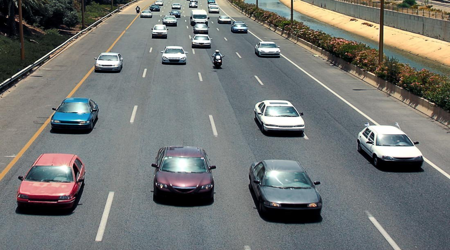

In [173]:
image = Image.open(requests.get("https://ix-cdn.b2e5.com/images/27094/27094_3063d356a3a54cc3859537fd23c5ba9d_1539205710.jpeg", stream=True).raw)
image = image.resize((450,250))
image_arr = np.array(image)
image

I will grey scale the image as this can help with output quality. Note, this is not always the case.  This part can be removed to check accuracy if the model under performs. 

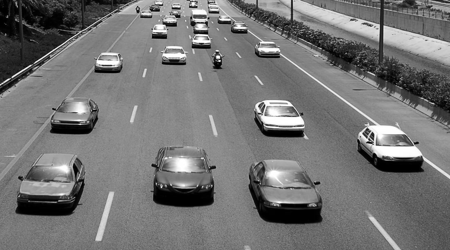

In [174]:
grey = cv2.cvtColor(image_arr, cv2.COLOR_BGR2GRAY)
Image.fromarray(grey)

The next processing step is applying some gaussian blur - this will remove the noise from the image.  Instead of using a box filter consisting of equal coefficients,  I will use the Gaussian kernel.  

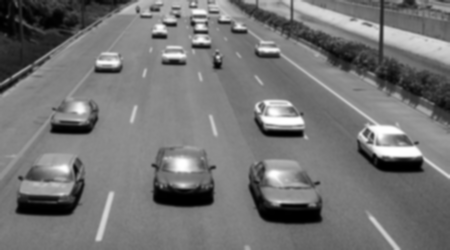

In [175]:
blur = cv2.GaussianBlur(grey, (5,5),0)
Image.fromarray(blur)

I will apply a dilation to the image - this is the opposite to erosion; if at least one pixel under the kernel is "1" it increases the white region in the image or size of foreground. 

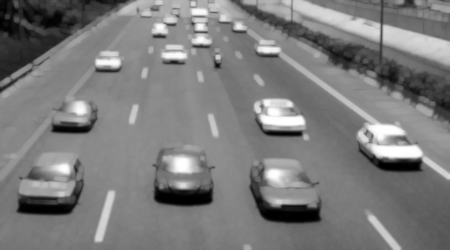

In [176]:
dilated = cv2.dilate(blur, np.ones((3,3)))
Image.fromarray(dilated)

The next step is to perform a Morphology transformation.  MorphologyEx is used to find the difference between the dilation and erosion of an image.  This process may need ellipitcal/circular shaped kernels,  so OpenCV has a function called getStructuringElement which I can pass the shape and size of the kernel into. 

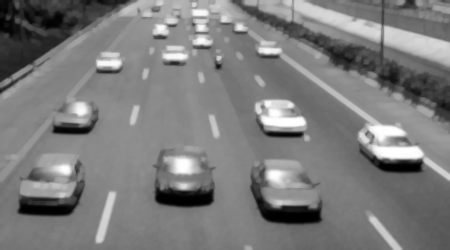

In [177]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)
Image.fromarray(closing)

Now,  I need to detect the cars in the image.   OpenCV provides a training method called Cascade Classifier Training that can be read using `cv2.CascadeClassifier()` I need to detect multiple objects, so I will ned to use `detectMultiScale` - this detects objects of different sizes in the input range.  The detected objects are returned as a list of rectangles. 



In [178]:
car_cascade_src = "cars.xml"
car_cascade = cv2.CascadeClassifier(car_cascade_src) # pre-trained model
cars = car_cascade.detectMultiScale(closing, 1.1, 1)

Now we will use the returned object contours and draw a rectangle around detected objects. 

9  cars found


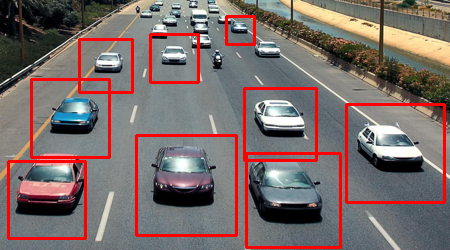

In [179]:
cnt = 0
for (x, y, w, h) in cars:
  cv2.rectangle(image_arr, (x, y), (x+w, y+h), (255, 0, 0),2)
  cnt += 1
print(cnt, " cars found")
Image.fromarray(image_arr)

As we can see, not all cars are detected due to arccuracy being below 100%. Lets try the modified image. 

9  cars found


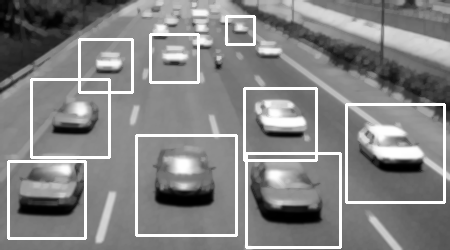

In [180]:
cnt = 0
for (x, y, w, h) in cars:
  cv2.rectangle(closing, (x, y), (x+w, y+h), (255, 0, 0),2)
  cnt += 1
print(cnt, " cars found")
Image.fromarray(closing)

We have the same accuracy, 9 cars are detected.  Let's try another vehicle.. a bus! 

In [181]:
image2 = Image.open(requests.get("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSRupk6apa8sChhyo1-rvbMZpAt7eBogfIfEsoCHb-OfWOkRl5aa3haGB4Hu1rHTSTt964&usqp=CAU", stream=True).raw)
image2 = image2.resize((450,250))
image_arr2 = np.array(image2)
grey2 = cv2.cvtColor(image_arr2, cv2.COLOR_BGR2GRAY)

As I am working with a bus image,  I will duplicate the code I used earlier but change the target. 

In [182]:
bus_cascade_src = "Bus_front.xml"
bus_cascade = cv2.CascadeClassifier(bus_cascade_src) # pre-trained model
bus = bus_cascade.detectMultiScale(grey2, 1.1, 1)

Perform the same contouring operation.. 

1  bus found


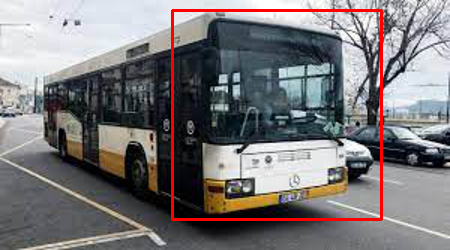

In [183]:
cnt = 0
for (x, y, w, h) in bus:
  cv2.rectangle(image_arr2, (x, y), (x+w, y+h), (255, 0, 0),2)
  cnt += 1
print(cnt, " bus found")
Image.fromarray(image_arr2)

Now, I am going to perform car detection and counting with a video.  To create the output video from fraames or images,  I need to use the `VideoWriter` method from OpenCV.  It takes a path with video extension as the first parameter, and the second parameter is the video codec for output format - FPS, width and height also need to be passed. 

In [184]:
cascade_src = "cars.xml"
video_src = "Cars.mp4"

cap = cv2.VideoCapture(video_src)
car_cascade = cv2.CascadeClassifier(cascade_src)
fourcc = cv2.VideoWriter_fourcc(*"DIVX")
video = cv2.VideoWriter('result.avi',fourcc, 15, (640,360))  

I will read the frames 1 by 1 from the input video, convert them to grayscale and using car cascade detect all cars in that particular frame.  

In [185]:
while True:
  ret, img = cap.read()

  if (type(img) == type(None)):
    break
  
  grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  cars = car_cascade.detectMultiScale(grey, 1.1, 2)

  for (x, y, w, h) in cars:
    cv2.rectangle(img,(x, y), (x+w, y+h), (0,255,255),2)

  video.write(img)
video.release()